# SELF-SUPERVISED REPRESENTATION LEARNING

# (a) (1) Word2Vec CBOW Model Pre-training on SST2 dataset.

In [1]:
import torch
import datasets  # hugging face

#dataset = datasets.load_dataset('tweets_hate_speech_detection') 
#dataset = datasets.load_dataset('yelp_review_full')  # large dataset
dataset = datasets.load_dataset('sst2')  # stanford sentiment treebank version 2 (SST2)

Found cached dataset sst2 (/data3/home/kedarnathp/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
#  Define the function for text cleanup(preprocess)
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
tqdm.pandas()

from bs4 import BeautifulSoup
import re

import pandas as pd


def preprocess(text: str):
    """
    Cleans(preprocesses) the reviews text before tokenizing it
    ----------
    text (str): raw review text data
    """
    emojis = r'[\U0001F600-\U0001F64F'\
           + r'\U0001F300-\U0001F5FF'\
           + r'\U0001F680-\U0001F6FF'\
           + r'\U0001F1E0-\U0001F1FF'\
           + r'\U00002702-\U000027B0'\
           + r'\U000024C2-\U0001F251]+'
    non_ASCII = r'[^\x00-\x7F]+'
    mentions = r'@[A-Za-z0-9_-]+'
    urls = r'https?://[A-Za-z0-9./]+'
    punctuation = r'[.,#!$%\^&\*;:{}=\-_`~()]'
    punctuation_space = r'[\/\\]'
    whitespace = r'\s+'
    
    # The text sometimes contains html elements, clean it up 
    soup = BeautifulSoup(text, 'html.parser')

    text = soup.get_text()

    # Replace all non-ASCII characters with space
    text = re.sub(non_ASCII, ' ', text)
    # Replace all emojis with space
    text = re.sub(emojis, ' ', text)
    # Remove Twitter mentions with usernames
    text = re.sub(mentions, '', text)
    # Remove all urls
    text = re.sub(urls, '', text)
    # Remove the punctuation marks
    text = re.sub(punctuation, '', text)
    # Removing some punctuation marks will fuse the words,
    # replace them with space instead
    text = re.sub(punctuation_space, ' ', text)
    # Remove multiple spaces, tabs and other whitespaces with one space
    text = re.sub(whitespace, ' ', text)

    # Convert text to lower case
    text = text.lower()
    return text

In [3]:
# Convert the train split to a pandas DataFrame
sst2 = pd.DataFrame(dataset['train'])
sst2.head()

,idx,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0


In [4]:
# let's remove alphanumeric
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer


ss = SnowballStemmer('english')
sw = stopwords.words('english')


def split_tokens(row):
    preprocessed_text = preprocess(row['sentence'])  # Call preprocess function from above, 'text' for yelp, 'tweet' for hate speech data
    
    # For simplicity let's remove alphanumeric 
    row['all_tokens'] = [ss.stem(i) for i in
                         re.split(r" +",
                                  re.sub(r"[^a-z ]", "",
                                         preprocessed_text))  # Use preprocessed_text instead of row['text']
                         if (i not in sw) and len(i)]
    return row


In [5]:
from collections import Counter

# Apply the split_tokens function to the dataset
preprocessed_dataset = dataset.map(split_tokens)

# Count the occurrences of each token in the 'all_tokens' column of the training split
counts = Counter([i for s in preprocessed_dataset['train']['all_tokens'] for i in s])
counts = {k: v for k, v in counts.items() if v > 10}  # Filtering (frequency)
vocab = list(counts.keys())  # filtered
n_v = len(vocab)
id2tok = dict(enumerate(vocab))
tok2id = {token: id for id, token in id2tok.items()}

# Now correct tokens
def remove_rare_tokens(row):
    row['tokens'] = [t for t in row['all_tokens'] if t in vocab]  # check if each word of all_tokens row is in vocab, include that review(if yes) 
    return row

# Apply the remove_rare_tokens function to the preprocessed_dataset
dataset = preprocessed_dataset.map(remove_rare_tokens)


Loading cached processed dataset at /data3/home/kedarnathp/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-3ee0a2228282ecd1.arrow
Loading cached processed dataset at /data3/home/kedarnathp/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-821d26a8a50587ab.arrow
Loading cached processed dataset at /data3/home/kedarnathp/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-b4537be1ed493863.arrow
Loading cached processed dataset at /data3/home/kedarnathp/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-9cd0a7d9151d882c.arrow
Loading cached processed dataset at /data3/home/kedarnathp/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-128e9d9416493bd6.arrow


In [6]:
# CBOW

def windowizer(row, wsize=3):
    """
    Windowizer function for Word2Vec. Converts sentence to sliding-window
    pairs.
    """
    doc = row['tokens']
    wsize = 3
    out = []
    for i, wd in enumerate(doc):
        target = tok2id[wd]  
        window = [i+j for j in  # upto distance of 3 (left and right)
                  range(-wsize, wsize+1, 1)
                  if (i+j>=0) &
                     (i+j<len(doc)) &
                     (j!=0)]

        out+=[(target, tok2id[doc[w]]) for w in window]     # context: list
    row['moving_window'] = out
    return row

dataset = dataset.map(windowizer)


Loading cached processed dataset at /data3/home/kedarnathp/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-d9763f45bbb728c2.arrow
Loading cached processed dataset at /data3/home/kedarnathp/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-021a71059e9adf6b.arrow
Loading cached processed dataset at /data3/home/kedarnathp/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-4b09065381c526ea.arrow


In [7]:
from torch.utils.data import Dataset, DataLoader

# pytorch format dataset
class Word2VecDataset(Dataset):
    """
    Takes a HuggingFace dataset as an input, to be used for a Word2Vec dataloader.
    """
    def __init__(self, dataset, vocab_size, wsize=3):
        self.dataset = dataset   # target
        self.vocab_size = vocab_size  
        self.data = [i for s in dataset['moving_window'] for i in s]   # context

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]




In [8]:
BATCH_SIZE = 2**10
N_LOADER_PROCS = 10  # cpu cores


dataloader = {} # dict of batches
for key in dataset.keys():   # for each split create pytorch dataloader objects
    dataloader[key] = DataLoader(Word2VecDataset(    
                                    dataset[key], vocab_size=n_v),
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  num_workers=N_LOADER_PROCS)



In [9]:
from torch import nn

size = 10
input = 3

def one_hot_encode(input, size):
    vec = torch.zeros(size).float()
    vec[input] = 1.0
    return vec

ohe = one_hot_encode(input, size)
linear_layer = nn.Linear(size, 1, bias=False)

# Set edge weights from 0 to 9 for easy reference randomly
with torch.no_grad():
    linear_layer.weight = nn.Parameter(
        torch.arange(10, dtype=torch.float).reshape(linear_layer.weight.shape))

print(linear_layer.weight)   # randomly assigned weights in order 0-9
print(linear_layer(ohe))   # x input


Parameter containing:
tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]], requires_grad=True)
tensor([3.], grad_fn=<SqueezeBackward3>)


In [10]:
embedding_layer = nn.Embedding(size, 1)

with torch.no_grad():
    embedding_layer.weight = nn.Parameter(
        torch.arange(10, dtype=torch.float
        ).reshape(embedding_layer.weight.shape))

print(embedding_layer.weight)
print(embedding_layer(torch.tensor(input)))



Parameter containing:
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]], requires_grad=True)
tensor([3.], grad_fn=<EmbeddingBackward0>)


In [22]:
# general W2V

class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        # layer takes an integer input (the word index) and returns a tensor of shape (batch_size, embedding_size).
        self.embed = nn.Embedding(vocab_size, embedding_size)  # v x n
        # maps the lower-dimensional representation of size embedding_size to a vector of size vocab_size (no bias) 
        # which represents predicted probabilities
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)  # n x v

    def forward(self, input):
        # Encode input to lower-dimensional representation
        hidden = self.embed(input)
        # Expand hidden layer to predictions
        logits = self.expand(hidden)
        return logits


In [23]:

# Instantiate the model
EMBED_SIZE = 100  
model = Word2Vec(n_v, EMBED_SIZE)

# Use CUDA if available, else use CPU
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')


print(device)
print(model)
model.to(device)

# Define training parameters
LR = 3e-4
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)



cuda:4
Word2Vec(
  (embed): Embedding(4632, 100)
  (expand): Linear(in_features=100, out_features=4632, bias=False)
)


In [13]:
from tqdm import tqdm  # For progress bars

progress_bar = tqdm(range(EPOCHS * len(dataloader['train'])))
running_loss = [] # array of losses
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader['train']:
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()  # for every new batch
        logits = model(input=context)  # input is context words
        loss = loss_fn(logits, center)  # Compute the loss between the predicted word and the one-hot encoded center word.
        epoch_loss += loss.item()  # Add the batch loss to the epoch loss.
        loss.backward() # Backpropagate the gradients through the model.
        optimizer.step()  # Update the model parameters using the optimizer.
        progress_bar.update(1)
    epoch_loss /= len(dataloader['train']) # : Divide the epoch loss by the number of batches in the training dataloader to get the average epoch loss.
    running_loss.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss:.4f}")


 10%|███████▋                                                                     | 1106/11110 [00:12<01:38, 101.74it/s]

Epoch 1/10, Loss: 8.3740


 20%|███████████████▎                                                             | 2218/11110 [00:22<01:28, 100.63it/s]

Epoch 2/10, Loss: 7.8512


 30%|███████████████████████                                                      | 3327/11110 [00:34<01:02, 124.68it/s]

Epoch 3/10, Loss: 7.3529


 40%|███████████████████████████████                                               | 4430/11110 [00:44<01:12, 92.63it/s]

Epoch 4/10, Loss: 7.0353


 50%|██████████████████████████████████████▍                                      | 5549/11110 [00:54<00:42, 129.35it/s]

Epoch 5/10, Loss: 6.8303


 60%|██████████████████████████████████████████████▋                               | 6653/11110 [01:05<00:54, 81.78it/s]

Epoch 6/10, Loss: 6.6807


 70%|█████████████████████████████████████████████████████▊                       | 7766/11110 [01:15<00:32, 104.28it/s]

Epoch 7/10, Loss: 6.5636


 80%|██████████████████████████████████████████████████████████████▍               | 8885/11110 [01:26<00:24, 90.52it/s]

Epoch 8/10, Loss: 6.4675


 90%|█████████████████████████████████████████████████████████████████████▏       | 9991/11110 [01:36<00:10, 106.86it/s]

Epoch 9/10, Loss: 6.3859


100%|███████████████████████████████████████████████████████████████████████████▉| 11102/11110 [01:47<00:00, 111.09it/s]

Epoch 10/10, Loss: 6.3150


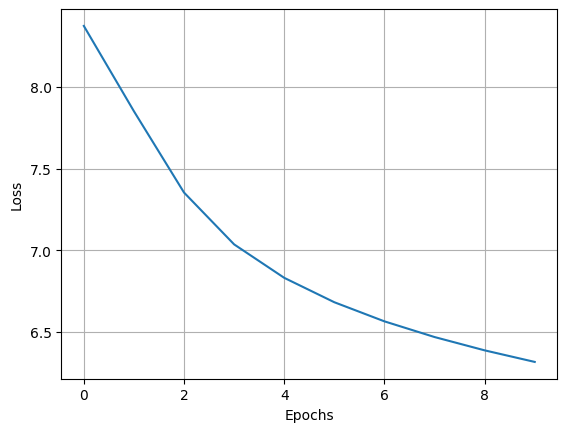

In [14]:
import matplotlib.pyplot as plt

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.plot(running_loss)


In [19]:
wordvecs = model.expand.weight.cpu().detach().numpy()
tokens = ['cinema', 'minimalist', 'good', 'rich']


In [16]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10):
    idx = tok2id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')  # cos theta
for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")


cinema ['one', 'movi', 'nt', 'film', 'see', 'thing', 'make', 'could', 'peopl', 'look'] 

minimalist ['characterist', 'blackandwhit', 'neglig', 'planet', 'delect', 'baroqu', 'brainpow', 'liabil', 'testud', 'code'] 

good ['make', 'movi', 'film', 'nt', 'like', 'stori', 'one', 'thing', 'much', 'way'] 

rich ['charact', 'much', 'beauti', 'work', 'wonder', 'love', 'person', 'life', 'littl', 'creat'] 



100%|████████████████████████████████████████████████████████████████████████████| 11110/11110 [02:00<00:00, 111.09it/s]

In [16]:
EPOCHS = 1500
progress_bar = tqdm(range(0, EPOCHS * len(dataloader['train']), 100))



running_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader['train']:
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()
        logits = model(input=context)  # CBOW  (better for sentiment classification)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader['train'])
    running_loss.append(epoch_loss)
    if((epoch+1) % 100 == 0):
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss:.4f}")


  0%|▏                                                                        | 3201/1666500 [05:02<43:43:13, 10.57it/s]
111089it [16:50, 128.90it/s]                                                                                            

Epoch 100/1500, Loss: 5.0934


222192it [34:22, 97.33it/s] 

Epoch 200/1500, Loss: 4.9184


333283it [52:05, 97.62it/s] 

Epoch 300/1500, Loss: 4.8533


444399it [1:10:34, 92.23it/s] 

Epoch 400/1500, Loss: 4.8199


555497it [1:29:46, 106.25it/s]

Epoch 500/1500, Loss: 4.7995


666565it [1:42:24, 381.83it/s]

Epoch 600/1500, Loss: 4.7856


777667it [1:50:50, 285.61it/s]

Epoch 700/1500, Loss: 4.7752


888778it [1:59:16, 255.94it/s]

Epoch 800/1500, Loss: 4.7675


999885it [2:07:39, 201.76it/s]

Epoch 900/1500, Loss: 4.7610


1110976it [2:15:24, 258.36it/s]

Epoch 1000/1500, Loss: 4.7558


1222060it [2:23:49, 454.83it/s]

Epoch 1100/1500, Loss: 4.7515


1333171it [2:31:18, 269.66it/s]

Epoch 1200/1500, Loss: 4.7477


1444268it [2:38:45, 344.81it/s]

Epoch 1300/1500, Loss: 4.7446


1555383it [2:46:15, 313.01it/s]

Epoch 1400/1500, Loss: 4.7417


1666476it [2:53:38, 465.87it/s]

Epoch 1500/1500, Loss: 4.7393


1666500it [2:53:48, 465.87it/s]

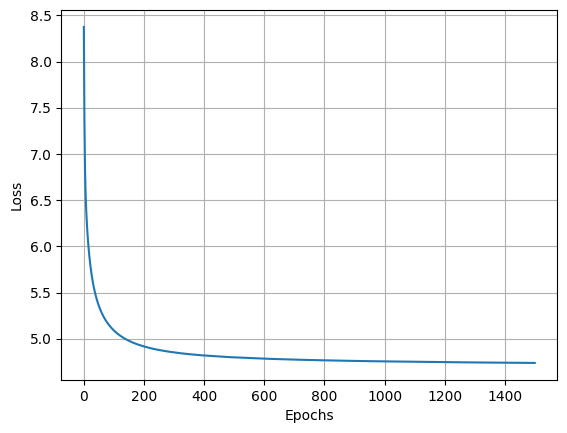

In [17]:
import matplotlib.pyplot as plt

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.plot(running_loss)


In [22]:
wordvecs_1500_epochs = model.expand.weight.cpu().detach().numpy()
dmat_1500_epochs = get_distance_matrix(wordvecs_1500_epochs, 'cosine')
for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat_1500_epochs)], "\n")


cinema ['requir', 'iconoclast', 'suppos', 'profil', 'broomfield', 'goer', 'french', 'kwan', 'ford', 'beat'] 

minimalist ['loyal', 'adequ', 'broil', 'guiltypleasur', 'thecash', 'miracul', 'storylin', 'cleverest', 'terri', 'ravish'] 

good ['film', 'movi', 'nt', 'could', 'look', 'littl', 'much', 'make', 'bit', 'work'] 

rich ['landscap', 'touch', 'breathtak', 'view', 'consist', 'group', 'enchant', 'hammi', 'irresist', 'beauti'] 



In [25]:
#torch.save(model.state_dict(), 'word2vec-sst2-1500epochs.checkpoint')
torch.save(model.state_dict(), 'word2vec-sst2-1500epochs.pth')




In [27]:
# load pre-trained model

model2 = Word2Vec(n_v, EMBED_SIZE)
model2.load_state_dict(torch.load('word2vec-sst2-1500epochs.pth'))
model2.eval()


Word2Vec(
  (embed): Embedding(4632, 100)
  (expand): Linear(in_features=100, out_features=4632, bias=False)
)

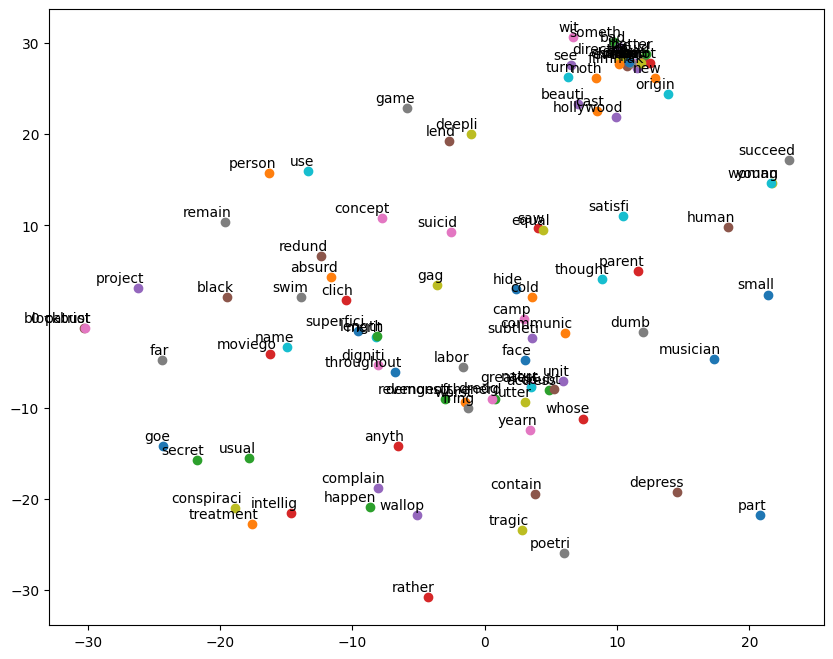

In [25]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract the word embeddings from your model:
word_embeddings = model.expand.weight.cpu().detach().numpy() # target word vectors

# Apply t-SNE to reduce the dimensionality to 2D:
tsne = TSNE(n_components=2, random_state=0)
word_embeddings_2d = tsne.fit_transform(word_embeddings)

# Create a function to plot the 2D word embeddings:
def plot_embeddings(embeddings, labels):
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

# Choose a subset of words to visualize (e.g., the top 100 most frequent words):
n_words = 100
subset_word_embeddings = word_embeddings_2d[:n_words]
subset_word_labels = [id2tok[i] for i in range(n_words)]

# call the plot_embeddings function to visualize the word embeddings:
plot_embeddings(subset_word_embeddings, subset_word_labels)


## (2) Word2Vec (Skip-gram) model with Negative sampling

In [27]:
# Compute the sampling probabilities for each word based on their frequency.

import numpy as np

def compute_sampling_probabilities(counts, exponent=0.75):
    total_count = sum(counts.values())
    freq_dist = {word: count / total_count for word, count in counts.items()}
    sampling_prob = np.array([freq_dist[word] for word in vocab]) ** exponent
    sampling_prob /= np.sum(sampling_prob)
    return sampling_prob


sampling_prob = compute_sampling_probabilities(counts)

def sample_negative_words(vocab, freq_dist, num_neg_samples):
    neg_samples = np.random.choice(vocab, size=num_neg_samples, replace=False, p=freq_dist)
    return neg_samples






In [28]:
# Modify the Word2VecDataset to return negative samples as well.

class Word2VecDataset(Dataset):
    def __init__(self, dataset, vocab_size, wsize=3, num_neg_samples=5, sampling_prob=None):
        self.dataset = dataset
        self.vocab_size = vocab_size
        self.data = [i for s in dataset['moving_window'] for i in s]
        self.num_neg_samples = num_neg_samples
        self.sampling_prob = sampling_prob

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        center, context = self.data[idx]
        negatives = sample_negative_words(vocab, self.sampling_prob, self.num_neg_samples)
        negative_ids = [tok2id[word] for word in negatives]
        return center, context, torch.tensor(negative_ids, dtype=torch.long)
    

In [29]:

BATCH_SIZE = 2**10
N_LOADER_PROCS = 10  # cpu cores


# Update the Word2Vec model to handle negative samples.
dataloader = {}
for key in dataset.keys():
    dataloader[key] = DataLoader(Word2VecDataset(
                                    dataset[key], vocab_size=n_v, sampling_prob=sampling_prob),
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  num_workers=N_LOADER_PROCS)



In [30]:

# Change the modelto handle positive and negative samples.
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.center_embed = nn.Embedding(vocab_size, embedding_size)
        self.context_embed = nn.Embedding(vocab_size, embedding_size)

    def forward(self, center, context, negatives):
        center_emb = self.center_embed(center)
        context_emb = self.context_embed(context)
        neg_emb = self.context_embed(negatives)

        pos_logits = torch.bmm(center_emb.unsqueeze(1), context_emb.unsqueeze(2)).squeeze()
        neg_logits = -torch.bmm(center_emb.unsqueeze(1), neg_emb.transpose(1, 2)).sum(dim=2)
        
        return pos_logits, neg_logits

   

In [31]:

# Instantiate the model
EMBED_SIZE = 100  
model = Word2Vec(n_v, EMBED_SIZE)

# Use CUDA if available, else use CPU
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')


print(device)
print(model)
model.to(device)

# Define training parameters
LR = 3e-4
EPOCHS = 20





cuda:1
Word2Vec(
  (center_embed): Embedding(4632, 100)
  (context_embed): Embedding(4632, 100)
)


In [32]:
# Change the modelto handle positive and negative samples.

def loss_fn(pos_logits, neg_logits, device):
    pos_logits = pos_logits.unsqueeze(1)  # Add a dimension to match neg_logits shape
    pos_targets = torch.ones(pos_logits.size()).to(device)
    neg_targets = torch.zeros(neg_logits.size()).to(device)
    targets = torch.cat((pos_targets, neg_targets), dim=0)
    logits = torch.cat((pos_logits, neg_logits), dim=0)
    loss = nn.BCEWithLogitsLoss()(logits, targets)
    return loss




optimizer = torch.optim.AdamW(model.parameters(), lr=LR)



In [24]:

# Update the training loop to handle negative samples.

progress_bar = tqdm(range(0, EPOCHS * len(dataloader['train']), 1))  # print train stats after every 1 epochs


running_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context, negatives in dataloader['train']:
        center, context, negatives = center.to(device), context.to(device), negatives.to(device)
        pos_logits, neg_logits = model(center, context, negatives)
        optimizer.zero_grad()
        loss = loss_fn(pos_logits, neg_logits, device)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    
    epoch_loss /= len(dataloader['train'])
    running_loss.append(epoch_loss)
    #if((epoch+1) % 100 == 0):
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss:.4f}")
    progress_bar.set_postfix(loss=epoch_loss)



 34%|██████████████████████████▋                                                   | 3801/11110 [10:36<20:24,  5.97it/s]

  3%|██▋                                                                          | 759/22220 [03:11<1:57:11,  3.05it/s]


  5%|███▎                                                             | 1111/22220 [04:36<1:26:13,  4.08it/s, loss=6.19]

Epoch 1/20, Loss: 6.1926



  8%|█████▍                                                           | 1853/22220 [07:57<1:30:34,  3.75it/s, loss=6.19]


 10%|██████▌                                                          | 2222/22220 [09:40<1:44:35,  3.19it/s, loss=5.61]

Epoch 2/20, Loss: 5.6148



 14%|█████████▎                                                       | 3203/22220 [14:11<1:44:03,  3.05it/s, loss=5.61]


 15%|█████████▊                                                       | 3333/22220 [14:42<1:01:23,  5.13it/s, loss=4.97]

Epoch 3/20, Loss: 4.9728



 18%|███████████▋                                                     | 3997/22220 [17:26<1:22:01,  3.70it/s, loss=4.97]


 20%|█████████████                                                    | 4444/22220 [19:13<1:20:30,  3.68it/s, loss=4.22]

Epoch 4/20, Loss: 4.2224



 23%|██████████████▊                                                  | 5048/22220 [21:42<1:11:20,  4.01it/s, loss=4.22]


 25%|████████████████▎                                                | 5555/22220 [23:57<1:01:41,  4.50it/s, loss=3.37]

Epoch 5/20, Loss: 3.3744



 30%|███████████████████▍                                             | 6636/22220 [28:51<1:13:16,  3.54it/s, loss=3.37]


 30%|████████████████████                                               | 6666/22220 [28:58<59:57,  4.32it/s, loss=2.53]

Epoch 6/20, Loss: 2.5259



 35%|██████████████████████▋                                          | 7757/22220 [33:55<1:13:17,  3.29it/s, loss=2.53]


 35%|███████████████████████▍                                           | 7777/22220 [33:59<50:52,  4.73it/s, loss=1.81]

Epoch 7/20, Loss: 1.8140



 37%|████████████████████████▊                                          | 8225/22220 [35:51<51:41,  4.51it/s, loss=1.81]


 40%|██████████████████████████▊                                        | 8882/22220 [38:29<48:17,  4.60it/s, loss=1.81]


 40%|██████████████████████████▊                                        | 8888/22220 [38:29<48:15,  4.60it/s, loss=1.26]

Epoch 8/20, Loss: 1.2650



 43%|████████████████████████████▉                                      | 9587/22220 [41:35<54:12,  3.88it/s, loss=1.26]


 45%|█████████████████████████████▎                                   | 9999/22220 [43:17<1:11:57,  2.83it/s, loss=0.87]

Epoch 9/20, Loss: 0.8705



 49%|████████████████████████████████▏                                 | 10823/22220 [46:51<52:01,  3.65it/s, loss=0.87]


 50%|████████████████████████████████▌                                | 11110/22220 [48:04<50:03,  3.70it/s, loss=0.592]

Epoch 10/20, Loss: 0.5919



 52%|█████████████████████████████████▉                               | 11592/22220 [50:03<40:28,  4.38it/s, loss=0.592]


 55%|███████████████████████████████████▊                             | 12221/22220 [52:38<46:49,  3.56it/s, loss=0.404]

Epoch 11/20, Loss: 0.4042



 59%|██████████████████████████████████████                           | 13013/22220 [55:56<36:25,  4.21it/s, loss=0.404]


 60%|███████████████████████████████████████                          | 13332/22220 [57:14<39:18,  3.77it/s, loss=0.273]

Epoch 12/20, Loss: 0.2733



 63%|████████████████████████████████████████▊                        | 13952/22220 [59:46<23:22,  5.89it/s, loss=0.273]


 65%|████████████████████████████████████████▉                      | 14443/22220 [1:01:46<30:54,  4.19it/s, loss=0.185]

Epoch 13/20, Loss: 0.1849



 67%|██████████████████████████████████████████▎                    | 14926/22220 [1:03:46<37:00,  3.28it/s, loss=0.185]


 70%|███████████████████████████████████████████▉                   | 15512/22220 [1:06:13<29:25,  3.80it/s, loss=0.185]


 70%|████████████████████████████████████████████                   | 15554/22220 [1:06:23<26:15,  4.23it/s, loss=0.127]

Epoch 14/20, Loss: 0.1265



 73%|█████████████████████████████████████████████▋                 | 16129/22220 [1:08:57<29:57,  3.39it/s, loss=0.127]


 74%|██████████████████████████████████████████████▉                | 16537/22220 [1:10:43<25:20,  3.74it/s, loss=0.127]


 75%|██████████████████████████████████████████████▌               | 16665/22220 [1:11:18<36:13,  2.56it/s, loss=0.0881]

Epoch 15/20, Loss: 0.0881



 78%|████████████████████████████████████████████████▍             | 17373/22220 [1:14:38<18:48,  4.30it/s, loss=0.0881]


 80%|█████████████████████████████████████████████████▌            | 17776/22220 [1:16:26<25:46,  2.87it/s, loss=0.0611]

Epoch 16/20, Loss: 0.0611



 83%|███████████████████████████████████████████████████▎          | 18384/22220 [1:19:15<14:50,  4.31it/s, loss=0.0611]


 85%|████████████████████████████████████████████████████▋         | 18887/22220 [1:21:29<11:25,  4.86it/s, loss=0.0436]

Epoch 17/20, Loss: 0.0436



 88%|██████████████████████████████████████████████████████▊       | 19633/22220 [1:24:53<09:14,  4.67it/s, loss=0.0436]


 90%|███████████████████████████████████████████████████████▊      | 19998/22220 [1:26:22<08:20,  4.44it/s, loss=0.0318]

Epoch 18/20, Loss: 0.0318



 93%|█████████████████████████████████████████████████████████▎    | 20555/22220 [1:28:28<05:49,  4.76it/s, loss=0.0318]


 95%|███████████████████████████████████████████████████████████▊   | 21109/22220 [1:29:59<02:52,  6.43it/s, loss=0.023]

Epoch 19/20, Loss: 0.0230



 98%|█████████████████████████████████████████████████████████████▌ | 21711/22220 [1:32:24<02:33,  3.32it/s, loss=0.023]


100%|██████████████████████████████████████████████████████████████| 22220/22220 [1:34:45<00:00,  3.10it/s, loss=0.0174]

Epoch 20/20, Loss: 0.0174


In [26]:
progress_bar = tqdm(range(0, EPOCHS * len(dataloader['train']), 1))  # print train stats after every 1 epochs


#running_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context, negatives in dataloader['train']:
        center, context, negatives = center.to(device), context.to(device), negatives.to(device)
        pos_logits, neg_logits = model(center, context, negatives)
        optimizer.zero_grad()
        loss = loss_fn(pos_logits, neg_logits, device)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    
    epoch_loss /= len(dataloader['train'])
    running_loss.append(epoch_loss)
    #if((epoch+1) % 100 == 0):
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss:.4f}")
    progress_bar.set_postfix(loss=epoch_loss)


  5%|███▎                                                             | 1111/22220 [04:34<32:36, 10.79it/s, loss=0.0136]

Epoch 1/20, Loss: 0.0136


 10%|██████▌                                                          | 2222/22220 [06:13<22:37, 14.73it/s, loss=0.0101]

Epoch 2/20, Loss: 0.0101


 15%|█████████▌                                                      | 3333/22220 [07:52<22:46, 13.82it/s, loss=0.00821]

Epoch 3/20, Loss: 0.0082


 20%|████████████▊                                                   | 4444/22220 [09:31<20:08, 14.71it/s, loss=0.00628]

Epoch 4/20, Loss: 0.0063


 25%|████████████████                                                | 5555/22220 [11:08<24:33, 11.31it/s, loss=0.00523]

Epoch 5/20, Loss: 0.0052


 30%|███████████████████▏                                            | 6666/22220 [12:48<17:27, 14.84it/s, loss=0.00443]

Epoch 6/20, Loss: 0.0044


 35%|██████████████████████▍                                         | 7777/22220 [14:28<17:18, 13.90it/s, loss=0.00356]

Epoch 7/20, Loss: 0.0036


 40%|█████████████████████████▌                                      | 8888/22220 [16:08<14:36, 15.20it/s, loss=0.00323]

Epoch 8/20, Loss: 0.0032


 45%|████████████████████████████▊                                   | 9999/22220 [17:48<19:26, 10.48it/s, loss=0.00264]

Epoch 9/20, Loss: 0.0026


 50%|███████████████████████████████▌                               | 11110/22220 [19:29<13:00, 14.23it/s, loss=0.00226]

Epoch 10/20, Loss: 0.0023


 55%|███████████████████████████████████▏                            | 12221/22220 [21:10<15:40, 10.63it/s, loss=0.0019]

Epoch 11/20, Loss: 0.0019


 60%|█████████████████████████████████████▊                         | 13332/22220 [22:54<12:01, 12.31it/s, loss=0.00177]

Epoch 12/20, Loss: 0.0018


 65%|████████████████████████████████████████▉                      | 14443/22220 [24:35<12:50, 10.09it/s, loss=0.00149]

Epoch 13/20, Loss: 0.0015


 70%|████████████████████████████████████████████▊                   | 15554/22220 [26:16<07:41, 14.45it/s, loss=0.0013]

Epoch 14/20, Loss: 0.0013


 75%|██████████████████████████████████████████████▌               | 16665/22220 [27:57<08:26, 10.96it/s, loss=0.000991]

Epoch 15/20, Loss: 0.0010


 80%|██████████████████████████████████████████████████▍            | 17776/22220 [29:38<06:38, 11.14it/s, loss=0.00103]

Epoch 16/20, Loss: 0.0010


 85%|████████████████████████████████████████████████████▋         | 18887/22220 [31:20<04:02, 13.74it/s, loss=0.000801]

Epoch 17/20, Loss: 0.0008


 90%|████████████████████████████████████████████████████████▋      | 19998/22220 [33:02<02:41, 13.80it/s, loss=0.00073]

Epoch 18/20, Loss: 0.0007


 95%|██████████████████████████████████████████████████████████▉   | 21109/22220 [34:43<01:49, 10.13it/s, loss=0.000686]

Epoch 19/20, Loss: 0.0007


100%|██████████████████████████████████████████████████████████████| 22220/22220 [36:26<00:00, 14.15it/s, loss=0.000666]

Epoch 20/20, Loss: 0.0007


100%|██████████████████████████████████████████████████████████████| 22220/22220 [36:38<00:00, 14.15it/s, loss=0.000666]

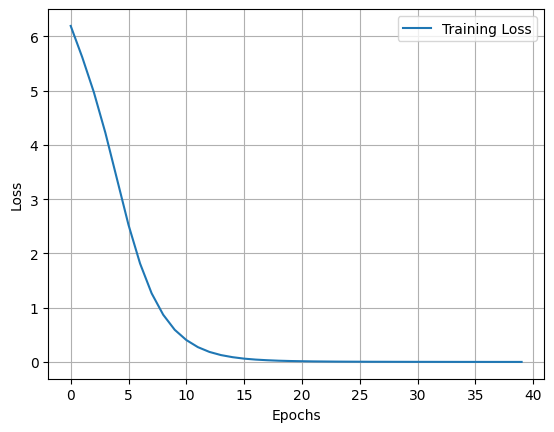

In [27]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(10, 5))
plt.plot(running_loss, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()



In [35]:
wordvecs = model.center_embed.weight.cpu().detach().numpy()
tokens = ['cinema', 'minimalist', 'good', 'rich']




In [36]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10):
    idx = tok2id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')  # cos theta
for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

cinema ['nt', 'comedi', 'even', 'minut', 'long', 'enjoy', 'film', 'two', 'watch', 'novel'] 

minimalist ['jacki', 'fellow', 'cloy', 'contrast', 'hard', 'quirk', 'fallibl', 'enough', 'independ', 'often'] 

good ['one', 'movi', 'like', 'look', 'make', 'charact', 'film', 'direct', 'way', 'enough'] 

rich ['world', 'carvey', 'kind', 'tale', 'tri', 'stori', 'episod', 'warm', 'peopl', 'never'] 



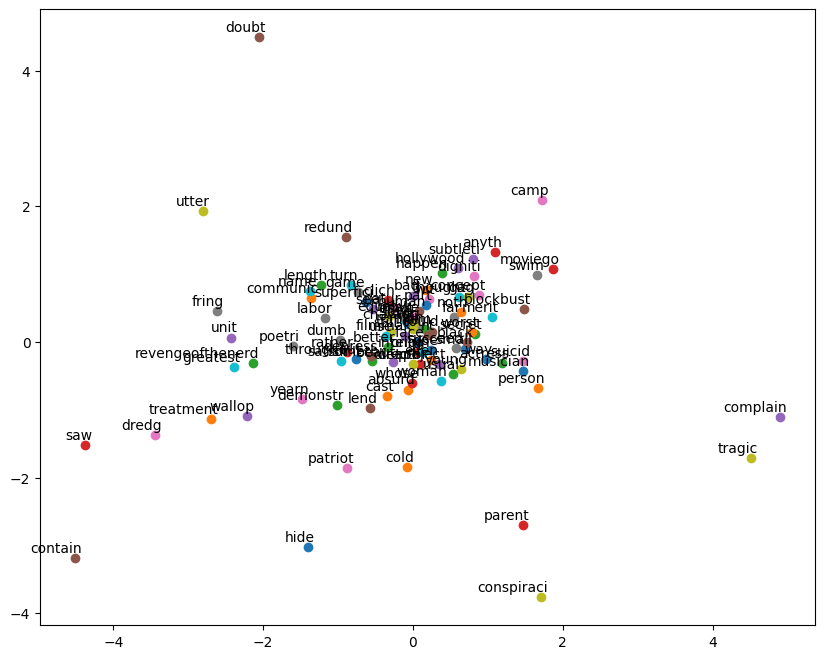

In [37]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract the word embeddings from your model:
word_embeddings = model.center_embed.weight.detach().cpu().numpy()  # target word vectors

# Apply t-SNE to reduce the dimensionality to 2D:
tsne = TSNE(n_components=2, random_state=0)
word_embeddings_2d = tsne.fit_transform(word_embeddings)

# Create a function to plot the 2D word embeddings:
def plot_embeddings(embeddings, labels):
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

# Choose a subset of words to visualize (e.g., the top 100 most frequent words):
n_words = 100
subset_word_embeddings = word_embeddings_2d[:n_words]
subset_word_labels = [id2tok[i] for i in range(n_words)]

# call the plot_embeddings function to visualize the word embeddings:
plot_embeddings(subset_word_embeddings, subset_word_labels)


In [32]:
# save model
torch.save(model.state_dict(), 'word2vec-sst2-negative_sampling-40epochs.pth')



In [33]:
# Load pre-trained model
model3 = Word2Vec(n_v, EMBED_SIZE)
model3.load_state_dict(torch.load('word2vec-sst2-negative_sampling-40epochs.pth'))
model3.eval()


Word2Vec(
  (center_embed): Embedding(4632, 100)
  (context_embed): Embedding(4632, 100)
)

# (b) NLP TASK: Sentiment Classification on IMDB dataset by comparing:

## 1. Our pre-trained word2vec (CBOW) model
## 2. Our pre-trained word2vec (skip-gram with negative sampling) model 
## 3. Gensim library word2vec (CBOW) pre-trained model 
## 4. Gensim library word2vec (skip-gram with negative sampling) pre-trained model 
## 5. Google's word2vec (Skip-gram) pre-trained model

## (1) Pre-trained word2vec (CBOW) model (Implemented and pre-trained from scratch)

In [35]:
import sys
import gc
import re
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np


from bs4 import BeautifulSoup
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt



In [36]:
imdb_df = pd.read_csv('IMDB_Dataset.csv')

# Remove rows with missing values from the data
imdb_df = imdb_df.dropna()

imdb_df.sample(5, random_state=0)

,review,sentiment
11841,John Cassavetes is on the run from the law. He...,positive
19602,It's not just that the movie is lame. It's mor...,negative
45519,"Well, if it weren't for Ethel Waters and a 7-y...",negative
25747,I find Alan Jacobs review very accurate concer...,positive
42642,This movie is simply awesome. It is so hilario...,positive


In [37]:
# Encode the sentiment labels by assigning an integer value for each unique category value

idx_to_sentiment = {k: v for k, v in enumerate(imdb_df['sentiment'].unique())}
sentiment_to_idx = {v: k for k, v in idx_to_sentiment.items()}
print(f'Encoded sentiment values: {sentiment_to_idx}')

Encoded sentiment values: {'positive': 0, 'negative': 1}


In [38]:
imdb_df['label'] = imdb_df['sentiment'].apply(lambda x: sentiment_to_idx[x])
imdb_df['label'] = imdb_df['label'].apply(lambda x: torch.tensor(x))
imdb_df.sample(5, random_state=0)

,review,sentiment,label
11841,John Cassavetes is on the run from the law. He...,positive,tensor(0)
19602,It's not just that the movie is lame. It's mor...,negative,tensor(1)
45519,"Well, if it weren't for Ethel Waters and a 7-y...",negative,tensor(1)
25747,I find Alan Jacobs review very accurate concer...,positive,tensor(0)
42642,This movie is simply awesome. It is so hilario...,positive,tensor(0)


In [39]:
#  Define the function for text cleanup(preprocess)

def preprocess(text: str):
    """
    Cleans(preprocesses) the reviews text before tokenizing it
    ----------
    text (str): raw review text data
    """
    emojis = r'[\U0001F600-\U0001F64F'\
           + r'\U0001F300-\U0001F5FF'\
           + r'\U0001F680-\U0001F6FF'\
           + r'\U0001F1E0-\U0001F1FF'\
           + r'\U00002702-\U000027B0'\
           + r'\U000024C2-\U0001F251]+'
    non_ASCII = r'[^\x00-\x7F]+'
    mentions = r'@[A-Za-z0-9_-]+'
    urls = r'https?://[A-Za-z0-9./]+'
    punctuation = r'[.,#!$%\^&\*;:{}=\-_`~()]'
    punctuation_space = r'[\/\\]'
    whitespace = r'\s+'
    
    # The text sometimes contains html elements, clean it up 
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text()

    # Replace all non-ASCII characters with space
    text = re.sub(non_ASCII, ' ', text)
    # Replace all emojis with space
    text = re.sub(emojis, ' ', text)
    # Remove Twitter mentions with usernames
    text = re.sub(mentions, '', text)
    # Remove all urls
    text = re.sub(urls, '', text)
    # Remove the punctuation marks
    text = re.sub(punctuation, '', text)
    # Removing some punctuation marks will fuse the words,
    # replace them with space instead
    text = re.sub(punctuation_space, ' ', text)
    # Remove multiple spaces, tabs and other whitespaces with one space
    text = re.sub(whitespace, ' ', text)

    # Convert text to lower case
    text = text.lower()
    return text

In [40]:
# create new column after preprocess
imdb_df['review_preprocessed'] = imdb_df['review'].progress_apply(preprocess)
imdb_df.sample(5, random_state=0)


 72%|██████████████████████████████████████████████████████▎                    | 36233/50000 [00:13<00:05, 2520.39it/s]


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [00:18<00:00, 2643.07it/s]


,review,sentiment,label,review_preprocessed
11841,John Cassavetes is on the run from the law. He...,positive,tensor(0),john cassavetes is on the run from the law he ...
19602,It's not just that the movie is lame. It's mor...,negative,tensor(1),it's not just that the movie is lame it's more...
45519,"Well, if it weren't for Ethel Waters and a 7-y...",negative,tensor(1),well if it weren't for ethel waters and a 7yea...
25747,I find Alan Jacobs review very accurate concer...,positive,tensor(0),i find alan jacobs review very accurate concer...
42642,This movie is simply awesome. It is so hilario...,positive,tensor(0),this movie is simply awesome it is so hilariou...


In [19]:
# load pre-trained model word2vec model

model2 = Word2Vec(n_v, EMBED_SIZE)
model2.load_state_dict(torch.load('word2vec-sst2-1500epochs.pth'))
model2.eval()


Word2Vec(
  (embed): Embedding(4632, 100)
  (expand): Linear(in_features=100, out_features=4632, bias=False)
)

In [20]:
print(model2)

Word2Vec(
  (embed): Embedding(4632, 100)
  (expand): Linear(in_features=100, out_features=4632, bias=False)
)


In [21]:
# splitting by space '' 
def create_vocab_mapping(reviews):
    vocab = set()
    for review in reviews:
        for word in review.split():
            vocab.add(word)
    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    return word_to_index

# Create the vocabulary mapping
reviews = imdb_df['review_preprocessed'].tolist() # list of reviews
vocab_mapping = create_vocab_mapping(reviews)   # word to index (id)


print("IMDB Vocab mapping size:", len(vocab_mapping))
print("Word2Vec model vocab size:", model2.embed.weight.shape[0])



IMDB Vocab mapping size: 262423
Word2Vec model vocab size: 4632


In [90]:
# Convert the IMDb reviews into word embeddings:

def review_to_embedding(review, model, tok2id):
    tokens = review.split()
    embeddings = []
    for token in tokens:
        if token in tok2id:
            token_id = tok2id[token]
            token_embedding = model.embed(torch.tensor(token_id)).detach().numpy()
            embeddings.append(token_embedding)
    if not embeddings:
        return None
    return np.mean(embeddings, axis=0)

imdb_df['embedding'] = imdb_df['review_preprocessed'].apply(lambda x: review_to_embedding(x, model2, tok2id))
imdb_df = imdb_df.dropna(subset=['embedding'])


### Naive Bayes Classifier

In [71]:

X = np.vstack(imdb_df['embedding'].values)
y = imdb_df['sentiment'].values

# Split the dataset into a training and a testing set, stratifying based on the labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [72]:
# Train the Naive Bayes classifier on the training set:

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)


GaussianNB()

In [73]:
# Evaluate the classifier on the testing set:
from sklearn.metrics import classification_report, accuracy_score

y_pred = gnb.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))


Accuracy: 0.699


              precision    recall  f1-score   support

    negative       0.68      0.76      0.72      5000
    positive       0.73      0.64      0.68      5000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



### Linear SVM  Classifier

In [92]:
from sklearn.svm import LinearSVC

X = np.vstack(imdb_df['embedding'].values)
y = imdb_df['sentiment'].values

# Split the dataset into a training and a testing set, stratifying based on the labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [93]:
#  create and train the Linear SVM classifier:
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)


LinearSVC()

In [94]:
y_pred = linear_svc.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print('\n')
print("Classification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.7467


Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.75      0.75      5000
    positive       0.75      0.75      0.75      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



## (2)  Pre-trained word2vec (skip-gram with negative sampling) model : Implemented and pre-trained from scratch

In [41]:
# Load pre-trained model
model3 = Word2Vec(n_v, EMBED_SIZE)
model3.load_state_dict(torch.load('word2vec-sst2-negative_sampling-40epochs.pth'))
model3.eval()


Word2Vec(
  (center_embed): Embedding(4632, 100)
  (context_embed): Embedding(4632, 100)
)

In [43]:
# splitting by space '' 
def create_vocab_mapping(reviews):
    vocab = set()
    for review in reviews:
        for word in review.split():
            vocab.add(word)
    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    return word_to_index

# Create the vocabulary mapping
reviews = imdb_df['review_preprocessed'].tolist() # list of reviews
vocab_mapping = create_vocab_mapping(reviews)   # word to index (id)

print("IMDB Vocab mapping size:", len(vocab_mapping))
print("Word2Vec model vocab size:", model3.center_embed.weight.shape[0])


IMDB Vocab mapping size: 262423
Word2Vec model vocab size: 4632


In [48]:
# Convert the IMDb reviews into word embeddings:

def review_to_embedding(review, model, tok2id):
    tokens = review.split()
    embeddings = []
    for token in tokens:
        if token in tok2id:
            token_id = tok2id[token]
            token_embedding = model.center_embed(torch.tensor(token_id)).detach().numpy()
            embeddings.append(token_embedding)
    if not embeddings:
        return None
    return np.mean(embeddings, axis=0)

imdb_df['embedding'] = imdb_df['review_preprocessed'].apply(lambda x: review_to_embedding(x, model3, tok2id))
imdb_df = imdb_df.dropna(subset=['embedding'])


In [64]:
from sklearn.svm import LinearSVC

X = np.vstack(imdb_df['embedding'].values)
y = imdb_df['sentiment'].values

# Split the dataset into a training and a testing set, stratifying based on the labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [65]:
#  create and train the Linear SVM classifier:
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)


LinearSVC()

In [66]:

from sklearn.metrics import classification_report, accuracy_score

y_pred = linear_svc.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print('\n')
print("Classification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.668


Classification Report:
               precision    recall  f1-score   support

    negative       0.67      0.67      0.67      5000
    positive       0.67      0.66      0.67      5000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



## (3) Using word2vec(CBOW) model: Implementation from gensim library

### (i) Pre-training gensim w2v cbow model on sst2 dataset

In [69]:
import torch
import datasets  # hugging face

dataset = datasets.load_dataset('sst2')  # stanford sentiment treebank

Found cached dataset sst2 (/data3/home/kedarnathp/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [70]:
#  Define the function for text cleanup(preprocess)
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
tqdm.pandas()

from bs4 import BeautifulSoup
import re

import pandas as pd


def preprocess(text: str):
    """
    Cleans(preprocesses) the reviews text before tokenizing it
    ----------
    text (str): raw review text data
    """
    emojis = r'[\U0001F600-\U0001F64F'\
           + r'\U0001F300-\U0001F5FF'\
           + r'\U0001F680-\U0001F6FF'\
           + r'\U0001F1E0-\U0001F1FF'\
           + r'\U00002702-\U000027B0'\
           + r'\U000024C2-\U0001F251]+'
    non_ASCII = r'[^\x00-\x7F]+'
    mentions = r'@[A-Za-z0-9_-]+'
    urls = r'https?://[A-Za-z0-9./]+'
    punctuation = r'[.,#!$%\^&\*;:{}=\-_`~()]'
    punctuation_space = r'[\/\\]'
    whitespace = r'\s+'
    
    # The text sometimes contains html elements, clean it up 
    soup = BeautifulSoup(text, 'html.parser')

    text = soup.get_text()

    # Replace all non-ASCII characters with space
    text = re.sub(non_ASCII, ' ', text)
    # Replace all emojis with space
    text = re.sub(emojis, ' ', text)
    # Remove Twitter mentions with usernames
    text = re.sub(mentions, '', text)
    # Remove all urls
    text = re.sub(urls, '', text)
    # Remove the punctuation marks
    text = re.sub(punctuation, '', text)
    # Removing some punctuation marks will fuse the words,
    # replace them with space instead
    text = re.sub(punctuation_space, ' ', text)
    # Remove multiple spaces, tabs and other whitespaces with one space
    text = re.sub(whitespace, ' ', text)

    # Convert text to lower case
    text = text.lower()
    return text

In [71]:
# Convert the train split to a pandas DataFrame
sst2 = pd.DataFrame(dataset['train'])
sst2.head()

,idx,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0


In [72]:
# create new column after preprocess

sst2['preprocessed_sentence'] = sst2['sentence'].progress_apply(preprocess)


#print(sst2.head())


sst2.sample(5, random_state=0)


100%|██████████████████████████████████████████████████████████████████████████| 67349/67349 [00:04<00:00, 15712.96it/s]


,idx,sentence,label,preprocessed_sentence
43787,43787,very pleasing at its best moments,1,very pleasing at its best moments
16159,16159,", american chai is enough to make you put away...",0,american chai is enough to make you put away ...
59015,59015,too much like an infomercial for ram dass 's l...,0,too much like an infomercial for ram dass 's l...
5108,5108,a stirring visual sequence,1,a stirring visual sequence
67052,67052,cool visual backmasking,1,cool visual backmasking


In [73]:
# Tokenize the sentences
sst2['tokenized_sentence'] = sst2['preprocessed_sentence'].apply(lambda x: x.split())


In [93]:
# use same window and embedding size and frequency of words

# Train a Word2Vec model using the gensim library:
from gensim.models import Word2Vec

# Train a Word2Vec model on the tokenized sentences of ss2 dataset
w2v_model = Word2Vec(sst2['tokenized_sentence'], vector_size=100, window=3, min_count=10, workers=4, sg = 0) # CBOW 


### (ii) Sentiment Classification on IMDB dataset 
### (using gensim w2v cbow model embeddings which are pre-trained on sst2 dataset)

In [94]:
# Update the review_to_embedding function to use the newly trained Word2Vec model:
def review_to_embedding(review, model):
    tokens = review.split()
    embeddings = []
    for token in tokens:
        if token in model.wv:
            token_embedding = model.wv[token]
            embeddings.append(token_embedding)
    if not embeddings:
        return None
    return np.mean(embeddings, axis=0)

imdb_df['embedding'] = imdb_df['review_preprocessed'].apply(lambda x: review_to_embedding(x, w2v_model))
imdb_df = imdb_df.dropna(subset=['embedding'])


In [101]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X = np.stack(imdb_df['embedding'].values)
y = imdb_df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

svm_clf = LinearSVC()
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print('\n')
print("Classification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.7401


Classification Report:
               precision    recall  f1-score   support

    negative       0.74      0.74      0.74      5000
    positive       0.74      0.74      0.74      5000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



## (4) Using word2vec(skip-gram with negative sampling) model: Implementation from gensim library 

### (i) Pre-training gensim w2v skip-gram with negative sampling model on sst2 dataset

In [74]:
# use same window and embedding size and frequency of words

# Train a Word2Vec model using the gensim library:
from gensim.models import Word2Vec

# Train a Word2Vec model on the tokenized sentences of ss2 dataset
w2v_model = Word2Vec(sst2['tokenized_sentence'], vector_size=100, window=3, min_count=10, workers=4, negative=5)  # Skip-gram


### (ii) Sentiment Classification on IMDB dataset 
### (using gensim w2v skip-gram with negative sampling model embeddings which are pre-trained on sst2 dataset)

In [75]:
# Update the review_to_embedding function to use the newly trained Word2Vec model:
def review_to_embedding(review, model):
    tokens = review.split()
    embeddings = []
    for token in tokens:
        if token in model.wv:
            token_embedding = model.wv[token]
            embeddings.append(token_embedding)
    if not embeddings:
        return None
    return np.mean(embeddings, axis=0)

imdb_df['embedding'] = imdb_df['review_preprocessed'].apply(lambda x: review_to_embedding(x, w2v_model))
imdb_df = imdb_df.dropna(subset=['embedding'])


In [78]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X = np.stack(imdb_df['embedding'].values)
y = imdb_df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

svm_clf = LinearSVC()
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print('\n')
print("Classification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.7356


Classification Report:
               precision    recall  f1-score   support

    negative       0.74      0.74      0.74      5000
    positive       0.74      0.73      0.74      5000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



## (5) Using Google's pre-trained Word2Vec Skip-Gram (with negative sampling) model 

In [129]:
import gensim
from gensim.models import KeyedVectors


In [130]:
# Load the pre-trained word2vec model by google
# link: https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300
model_path = 'GoogleNews-vectors-negative300.bin'
word_vectors = KeyedVectors.load_word2vec_format(model_path, binary=True)




In [131]:
def review_to_embedding(review, model):
    tokens = review.split()
    embeddings = []
    for token in tokens:
        if token in model:
            token_embedding = model[token]
            embeddings.append(token_embedding)
    if not embeddings:
        return None
    return np.mean(embeddings, axis=0)


In [132]:
imdb_df['google_embedding'] = imdb_df['review_preprocessed'].apply(lambda x: review_to_embedding(x, model))
imdb_df = imdb_df.dropna(subset=['google_embedding'])


In [133]:
from sklearn.model_selection import train_test_split


X_google = np.vstack(imdb_df['google_embedding'].values)
y_google = imdb_df['sentiment'].values

# Split the dataset into a training and a testing set, stratifying based on the labels
X_train_google, X_test_google, y_train_google, y_test_google = train_test_split(X_google, y_google, test_size=0.2, random_state=0, stratify=y_google)




In [134]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# Create and train the Linear SVM classifier:
linear_svc_google = LinearSVC()
linear_svc_google.fit(X_train_google, y_train_google)

y_pred_google = linear_svc_google.predict(X_test_google)

print("Test Accuracy with Google's pre-trained Word2Vec:", accuracy_score(y_test_google, y_pred_google))
print('\n')
print("Classification Report:\n", classification_report(y_test_google, y_pred_google))




Test Accuracy with Google's pre-trained Word2Vec: 0.8444


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.84      0.84      5000
    positive       0.84      0.85      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## Visualization of Results through Bar plots

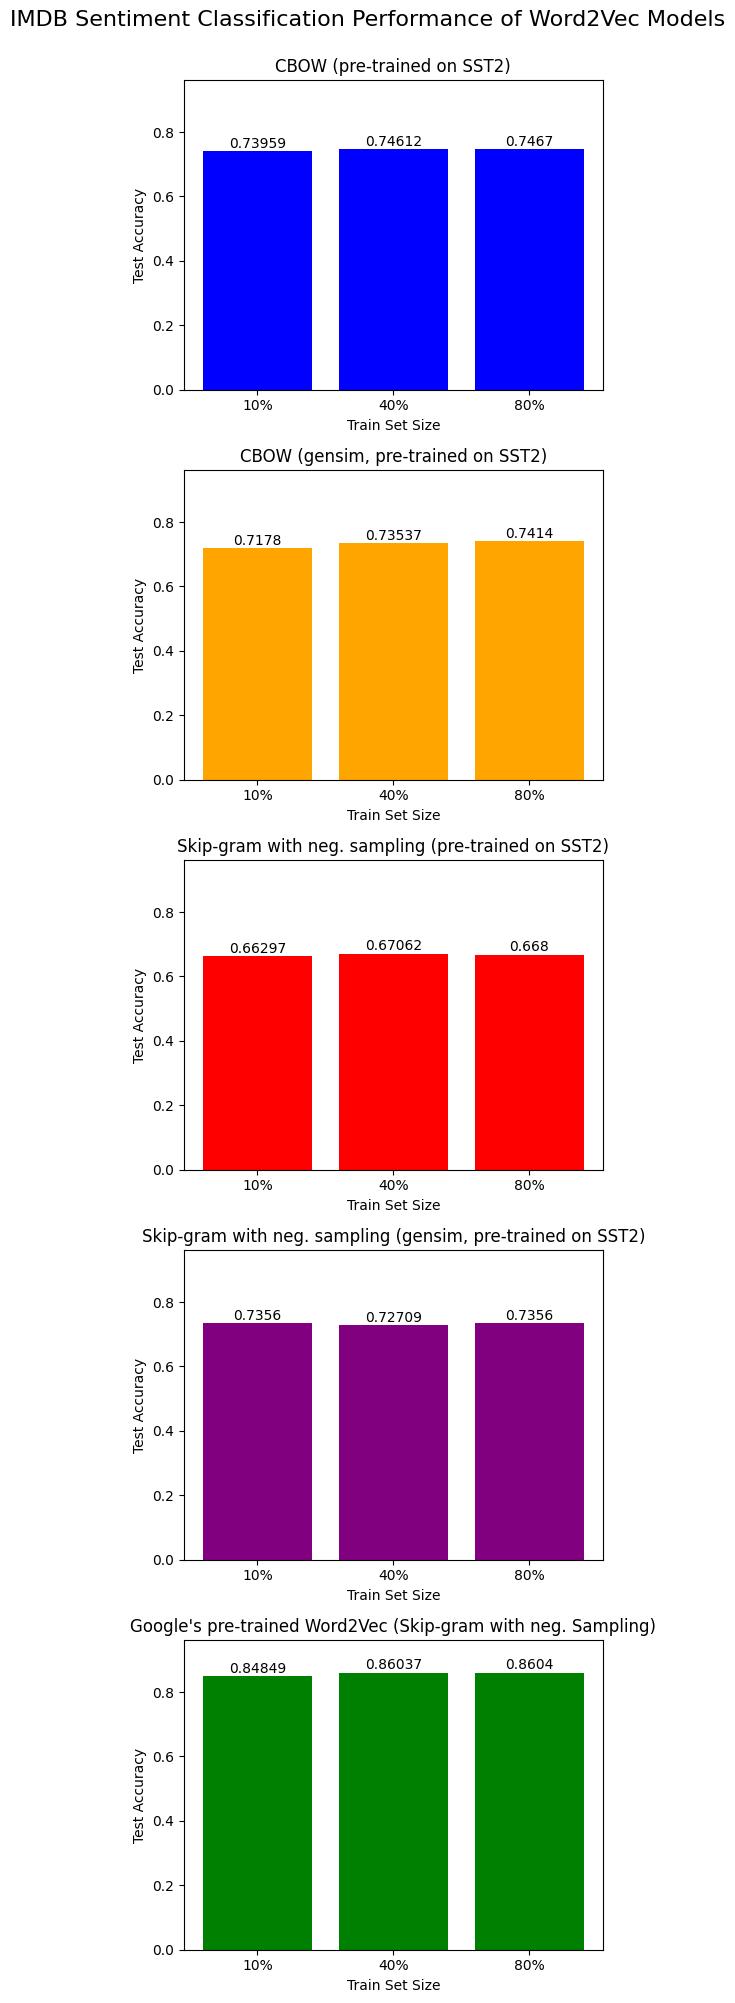

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plot A (CBOW from scratch)
a_train = [0.7395942132047378, 0.7461248708290277, 0.7467]
a_labels = ['10%', '40%', '80%']

# Data for plot B (CBOW from gensim)
b_train = [0.7178, 0.7353666666666666, 0.7414]
b_labels = ['10%', '40%', '80%']

# Data for plot C (Skip-gram with negative sampling from scratch)
c_train = [0.6629702882286274, 0.6706223540784693, 0.668]
c_labels = ['10%', '40%', '80%']

# Data for plot D (Skip-gram with negative sampling from gensim)
d_train = [0.7356, 0.727090903030101, 0.7356]
d_labels = ['10%', '40%', '80%']

# Data for plot E (Google's pre-trained Word2Vec)
e_train = [0.8484888888888888, 0.8603666666666666, 0.8604]
e_labels = ['10%', '40%', '80%']

# Plot the bar plots vertically
fig, ax = plt.subplots(5, 1, figsize=(5, 20))

ax[0].bar(a_labels, a_train, color='b')
ax[0].set_title('CBOW (pre-trained on SST2)')
ax[0].set_xlabel('Train Set Size')
ax[0].set_ylabel('Test Accuracy')

ax[1].bar(b_labels, b_train, color='orange')
ax[1].set_title('CBOW (gensim, pre-trained on SST2)')
ax[1].set_xlabel('Train Set Size')
ax[1].set_ylabel('Test Accuracy')

ax[2].bar(c_labels, c_train, color='r')
ax[2].set_title('Skip-gram with neg. sampling (pre-trained on SST2)')
ax[2].set_xlabel('Train Set Size')
ax[2].set_ylabel('Test Accuracy')

ax[3].bar(d_labels, d_train, color='purple')
ax[3].set_title('Skip-gram with neg. sampling (gensim, pre-trained on SST2)')
ax[3].set_xlabel('Train Set Size')
ax[3].set_ylabel('Test Accuracy')

ax[4].bar(e_labels, e_train, color='g')
ax[4].set_title("Google's " + 'pre-trained Word2Vec (Skip-gram with neg. Sampling)')
ax[4].set_xlabel('Train Set Size')
ax[4].set_ylabel('Test Accuracy')

# Set y-axis limits to be the same for all plots
max_acc = max(max(a_train), max(b_train), max(c_train), max(d_train), max(e_train))
for axis in ax:
    axis.set_ylim([0, max_acc + 0.1])

# Display values on top of the bars
for axis, data in zip(ax, [a_train, b_train, c_train, d_train, e_train]):
    for i, v in enumerate(data):
        axis.text(i, v + 0.01, str(round(v, 5)), ha='center')

# Add a heading to the graph
fig.suptitle("IMDB Sentiment Classification Performance of Word2Vec Models", fontsize=16, y=0.999)

plt.tight_layout()
plt.show()

In [3]:
! pip install prettytable



In [5]:
from prettytable import PrettyTable

data = [
    ["LSTM", 0.5123, 0.8305, 0.8687],
    ["Naive Bayes", 0.8515, 0.8727, 0.8878],
    ["Linear SVC", 0.8657, 0.8931, 0.9086],
    ["BERT", 0.8970, 0.9211, 0.9296],
    ["CBOW (Scratch)", 0.7396, 0.7461, 0.7467],
    ["CBOW (Gensim)", 0.7178, 0.7354, 0.7414],
    ["Skip-gram (Scratch)", 0.6630, 0.6706, 0.6680],
    ["Skip-gram (Gensim)", 0.7356, 0.7271, 0.7356],
    ["Pre-trained Word2Vec", 0.8485, 0.8604, 0.8604],
]

headers = ["Model", "10% Train Data", "40% Train Data", "80% Train Data"]

table = PrettyTable()

# Set the table headers
table.field_names = [f"\033[1;36m{header}\033[0m" for header in headers]

# Add the data rows to the table
for row in data:
    table.add_row(row)

print(table)


+----------------------+----------------+----------------+----------------+
|        Model         | 10% Train Data | 40% Train Data | 80% Train Data |
+----------------------+----------------+----------------+----------------+
|         LSTM         |     0.5123     |     0.8305     |     0.8687     |
|     Naive Bayes      |     0.8515     |     0.8727     |     0.8878     |
|      Linear SVC      |     0.8657     |     0.8931     |     0.9086     |
|         BERT         |     0.897      |     0.9211     |     0.9296     |
|    CBOW (Scratch)    |     0.7396     |     0.7461     |     0.7467     |
|    CBOW (Gensim)     |     0.7178     |     0.7354     |     0.7414     |
| Skip-gram (Scratch)  |     0.663      |     0.6706     |     0.668      |
|  Skip-gram (Gensim)  |     0.7356     |     0.7271     |     0.7356     |
| Pre-trained Word2Vec |     0.8485     |     0.8604     |     0.8604     |
+----------------------+----------------+----------------+----------------+
